## Compare ChebyKAN's ability in function interpolation with MLP

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from ChebyKAN import ChebyKANLayer
from kan import KAN

In [2]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise
    
    return y

In [3]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


class ChebyKAN(nn.Module):
    def __init__(self):
        super(ChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(1, 8, 8)
        self.chebykan2 = ChebyKANLayer(8, 1, 8)

    def forward(self, x):
        x = self.chebykan1(x)
        x = self.chebykan2(x)
        return x
    
class layer2KAN(nn.Module):
    def __init__(self):
        super(layer2KAN, self).__init__()
        self.kan1 = KAN(width=[1, 8], grid=5, k=3, seed=0)
        self.kan2 = KAN(width=[8, 1], grid=5, k=3, seed=0)

    def forward(self, x):
        x = self.kan1(x)
        x = self.kan2(x)
        return x

In [4]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
cheby_model = ChebyKAN()
kan_model = layer2KAN()
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(kan_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

cheby_losses = []
mlp_losses = []

# Train the models
epochs = 200000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = kan_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby.backward()
    optimizer_cheby.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, KAN Loss: {loss_cheby.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_cheby = kan_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Epoch 1/6000, KAN Loss: 0.8352, MLP Loss: 0.5397
Epoch 101/6000, KAN Loss: 0.2205, MLP Loss: 0.2309
Epoch 201/6000, KAN Loss: 0.2198, MLP Loss: 0.2293
Epoch 301/6000, KAN Loss: 0.2188, MLP Loss: 0.2286
Epoch 401/6000, KAN Loss: 0.2171, MLP Loss: 0.2281
Epoch 501/6000, KAN Loss: 0.1845, MLP Loss: 0.2266
Epoch 601/6000, KAN Loss: 0.1421, MLP Loss: 0.2228
Epoch 701/6000, KAN Loss: 0.1319, MLP Loss: 0.2210
Epoch 801/6000, KAN Loss: 0.1163, MLP Loss: 0.2229
Epoch 901/6000, KAN Loss: 0.0671, MLP Loss: 0.2204
Epoch 1001/6000, KAN Loss: 0.0471, MLP Loss: 0.2202
Epoch 1101/6000, KAN Loss: 0.0447, MLP Loss: 0.2199
Epoch 1201/6000, KAN Loss: 0.0437, MLP Loss: 0.2194
Epoch 1301/6000, KAN Loss: 0.0426, MLP Loss: 0.2190
Epoch 1401/6000, KAN Loss: 0.0418, MLP Loss: 0.2185
Epoch 1501/6000, KAN Loss: 0.0415, MLP Loss: 0.2181
Epoch 1601/6000, KAN Loss: 0.0415, MLP Loss: 0.2177
Ep

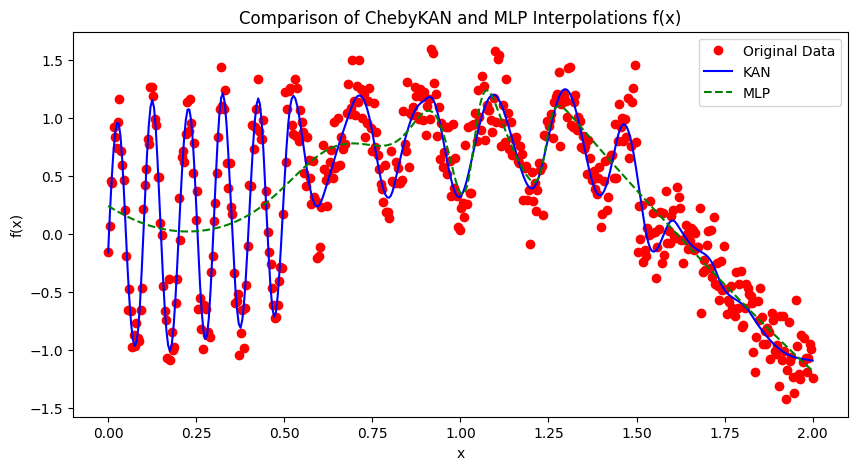

In [6]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original Data')
plt.plot(x_test.numpy(), y_pred_cheby.numpy(), 'b-', label='KAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'g--', label='MLP')
plt.title('Comparison of ChebyKAN and MLP Interpolations f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

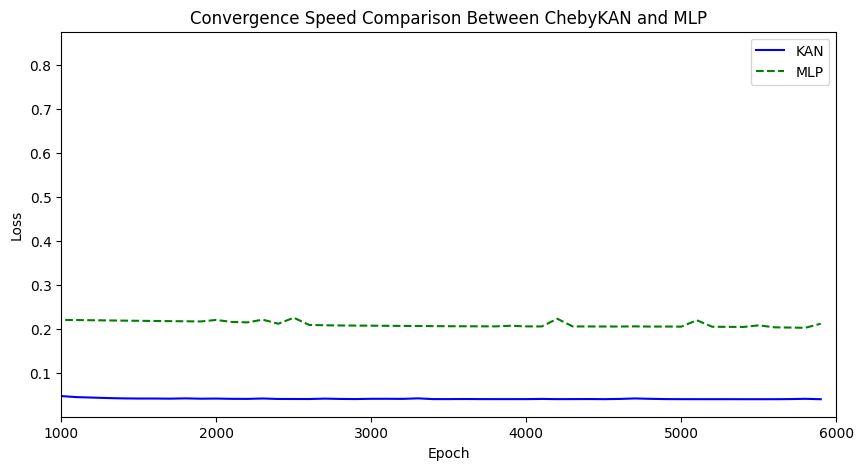

In [8]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), cheby_losses, 'b-', label='KAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'g--', label='MLP')
plt.title('Convergence Speed Comparison Between ChebyKAN and MLP')
plt.xlim(1000, epochs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()